In [146]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, recall_score


In [147]:
churn_data = pd.read_csv(r"D:\datascience__\end to end data sets-20230507T155014Z-001\end to end data sets\Churn_Modelling.csv")

In [148]:
churn_data.shape

(10000, 14)

In [149]:
churn_data.head().T

,0,1,2,3,4
RowNumber,1,2,3,4,5
CustomerId,15634602,15647311,15619304,15701354,15737888
Surname,Hargrave,Hill,Onio,Boni,Mitchell
CreditScore,619,608,502,699,850
Geography,France,Spain,France,France,Spain
Gender,Female,Female,Female,Female,Female
Age,42,41,42,39,43
Tenure,2,1,8,1,2
Balance,0.0,83807.86,159660.8,0.0,125510.82
NumOfProducts,1,1,3,2,1


About the data:

RowNumber: Row Numbers from 1 to 10000

CustomerId: Unique Ids for bank customer identification

Surname: Customer's last name

CreditScore: Credit score of the customer

Geography: The country from which the customer belongs

Gender: Male or Female

Age: Age of the customer

Tenure: Number of years for which the customer has been with the bank

Balance: Bank balance of the customer

NumOfProducts: Number of bank products the customer is utilising

HasCrCard: Whether the customer owns a credit card or not

IsActiveMember: whether the customer is an active member or not

EstimatedSalary: Customer's estimated salary

Exited: Target variable, whether the customer has left/will continu with the bank services


In [150]:
churn_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB



The data types are of 'object' or 'int' types.Let's convert them from 'object' to 'category' type.

There's no null values in the dataset.

The columns: RowNumber, CustomerId, Surname are unique to every customer and is insignificant to the data analysis process. So, let's drop them.



In [151]:
churn_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)

In [152]:
cat_cols = []
for cols in churn_data.select_dtypes("object"):
    cat_cols.append(cols)
int_cols = []
for cols in churn_data.select_dtypes(["int64", "float64"]):
    int_cols.append(cols)

The features: CreditScore, Age, NumOfProducts have outliers but they cannot be removed as those are possible factors in real-life.

The numerical columns: 'HasCrCard','IsActiveMember','Exited' are actually bivariate numerical categorical columns. Let's change them as well.

In [153]:
cat_cols.extend(['HasCrCard', 'IsActiveMember', 'Exited'])

In [154]:
cat_cols

['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']

In [155]:
churn_data[cat_cols] = churn_data[cat_cols].astype("category")

In [156]:
int_cols.remove('HasCrCard')
int_cols.remove('IsActiveMember')
int_cols.remove('Exited')
int_cols

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [157]:
churn_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
HasCrCard,10000.0,2.0,1.0,7055.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IsActiveMember,10000.0,2.0,1.0,5151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EstimatedSalary,10000.0,NaN,NaN,NaN,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


In [158]:
#scaling up features
from sklearn.preprocessing import LabelEncoder

#target column
tgt_col = ['Exited']

#categorical columns
category_names = churn_data.nunique()[churn_data.nunique() < 5].keys().tolist()
category_names = [x for x in category_names if x not in tgt_col]

#numerical columns
num_cols = [i for i in churn_data.columns if i not in category_names+tgt_col]

#binary columns
bin_cols = churn_data.nunique()[churn_data.nunique()==2].keys().tolist()

#multi-columns
multi_cols = [i for i in category_names if i not in bin_cols]

#Label Encoding Binary columns
le = LabelEncoder()
for i in bin_cols:
    churn_data[i] = le.fit_transform(churn_data[i])

#duplicating cols for multi-value columns
churn_data = pd.get_dummies(data=churn_data, columns=multi_cols)

In [159]:
churn_data_copy = churn_data.copy()

In [160]:
#Normalising Numerical columns
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
churn_data[num_cols] = minmax.fit_transform(churn_data[num_cols].values)

In [161]:
#Model Building for Scaled Data
cols = [i for i in churn_data.columns if i not  in tgt_col]
X_scaled = churn_data[cols]
Y_scaled = churn_data[tgt_col]

#Model Building for Unscaled Data
cols = [i for i in churn_data_copy.columns if i not  in tgt_col]
X_unscaled = churn_data_copy[cols]
Y_unscaled = churn_data_copy[tgt_col]

In [162]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [163]:
decision_tree_model = DecisionTreeClassifier()

In [164]:
#using stratified K-Fold Cross Validation to split train and test for scaled data
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
i=1
for train_index, test_index in folds.split(X_scaled,Y_scaled):
    print("\n {} of KFold".format(i,folds.n_splits))
    X_scaled_train,X_scaled_test = X_scaled.iloc[train_index],X_scaled.iloc[test_index]
    Y_scaled_train,Y_scaled_test = Y_scaled.iloc[train_index],Y_scaled.iloc[test_index]
    decision_tree_model.fit(X_scaled_train,Y_scaled_train)
    y_scaled_test_pred = decision_tree_model.predict(X_scaled_test)

    print("PERFORMANCE FOR SCALED DATA")
    dt_scores = cross_val_score(decision_tree_model, X_scaled_train, Y_scaled_train, cv=5)
    print("Mean cross validation score: {}".format(np.mean(dt_scores)))
    print("DT Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
    print("DT Classification Report: \n")
    print(classification_report(Y_scaled_test, y_scaled_test_pred))
    i=i+1


 1 of KFold
PERFORMANCE FOR SCALED DATA
Mean cross validation score: 0.7937777777777777
DT Confusion Matrix:
 [[690 106]
 [105  99]]
DT Classification Report: 

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       796
           1       0.48      0.49      0.48       204

    accuracy                           0.79      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.79      0.79      0.79      1000


 2 of KFold
PERFORMANCE FOR SCALED DATA
Mean cross validation score: 0.7905555555555555
DT Confusion Matrix:
 [[688 108]
 [104 100]]
DT Classification Report: 

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       796
           1       0.48      0.49      0.49       204

    accuracy                           0.79      1000
   macro avg       0.67      0.68      0.68      1000
weighted avg       0.79      0.79      0.79      1000


 3 of KFold
PERFORMAN

In [165]:
#using stratified K-Fold Cross Validation to split train and test for unscaled data
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
i=1
for train_index, test_index in folds.split(X_unscaled,Y_unscaled):
    print("\n {} of KFold".format(i,folds.n_splits))
    X_unscaled_train,X_unscaled_test = X_unscaled.iloc[train_index],X_unscaled.iloc[test_index]
    Y_unscaled_train,Y_unscaled_test = Y_unscaled.iloc[train_index],Y_unscaled.iloc[test_index]
    decision_tree_model.fit(X_unscaled_train,Y_unscaled_train)
    y_unscaled_test_pred = decision_tree_model.predict(X_unscaled_test)

    print("PERFORMANCE FOR UNSCALED DATA")
    dt_scores = cross_val_score(decision_tree_model, X_unscaled_train, Y_unscaled_train, cv=5)
    print("Mean cross validation score: {}".format(np.mean(dt_scores)))
    print("DT Confusion Matrix:\n",confusion_matrix(Y_unscaled_test, y_unscaled_test_pred))
    print("DT Classification Report: \n")
    print(classification_report(Y_unscaled_test, y_unscaled_test_pred))
    i=i+1


 1 of KFold
PERFORMANCE FOR UNSCALED DATA
Mean cross validation score: 0.7957777777777777
DT Confusion Matrix:
 [[690 106]
 [103 101]]
DT Classification Report: 

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       796
           1       0.49      0.50      0.49       204

    accuracy                           0.79      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.79      0.79      0.79      1000


 2 of KFold
PERFORMANCE FOR UNSCALED DATA
Mean cross validation score: 0.7874444444444444
DT Confusion Matrix:
 [[700  96]
 [108  96]]
DT Classification Report: 

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       796
           1       0.50      0.47      0.48       204

    accuracy                           0.80      1000
   macro avg       0.68      0.67      0.68      1000
weighted avg       0.79      0.80      0.79      1000


 3 of KFold
PERFO

In [166]:
#Using Grid search to vary parameters and figure out best parameters
from sklearn.model_selection import GridSearchCV

g_cv = GridSearchCV(DecisionTreeClassifier(random_state=0),
              param_grid={'min_samples_split': np.linspace(0.001,0.05,20,endpoint=True),
                          'criterion': ["gini", "entropy", "log_loss"], 
                          'splitter': ["best", "random"], 
                          'max_depth': np.linspace(1,10,10,endpoint=True), 
                          'min_samples_leaf': np.linspace(0.001,0.010,20,endpoint=True)},
              cv=5, refit=True)

g_cv.fit(X_scaled_train, Y_scaled_train)
print("Best Params:\n",g_cv.best_params_)

result = g_cv.cv_results_
#print(result)
y_scaled_test_pred = g_cv.best_estimator_.predict(X_scaled_test)
print("DT Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
print("DT Classification Report: \n")
print(classification_report(Y_scaled_test, y_scaled_test_pred))

Best Params:
 {'criterion': 'entropy', 'max_depth': 6.0, 'min_samples_leaf': 0.005263157894736842, 'min_samples_split': 0.016473684210526317, 'splitter': 'best'}
DT Confusion Matrix:
 [[767  30]
 [108  95]]
DT Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       797
           1       0.76      0.47      0.58       203

    accuracy                           0.86      1000
   macro avg       0.82      0.72      0.75      1000
weighted avg       0.85      0.86      0.85      1000



In [167]:
#predicting with best model params:
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=6.0, min_samples_leaf=0.006, min_samples_split=0.016, splitter='best')
decision_tree_model.fit(X_scaled_train,Y_scaled_train)
y_scaled_test_pred = decision_tree_model.predict(X_scaled_test)

In [168]:
print("DT Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
print("DT Classification Report: \n")
print(classification_report(Y_scaled_test, y_scaled_test_pred))

DT Confusion Matrix:
 [[767  30]
 [108  95]]
DT Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       797
           1       0.76      0.47      0.58       203

    accuracy                           0.86      1000
   macro avg       0.82      0.72      0.75      1000
weighted avg       0.85      0.86      0.85      1000



,0
Age,0.399936
NumOfProducts_2,0.239022
Balance,0.115831
NumOfProducts_1,0.097347
IsActiveMember,0.082006
Geography_Germany,0.047131
Gender,0.006901
EstimatedSalary,0.006471
CreditScore,0.005355
Tenure,0.000000


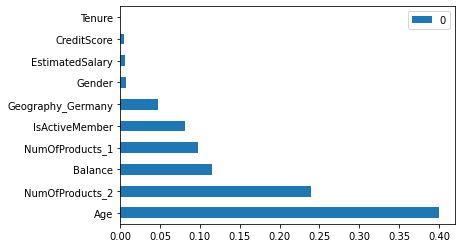

In [169]:
feat_importances = pd.DataFrame(decision_tree_model.feature_importances_, index=X_scaled_train.columns)
feat_importances = feat_importances.sort_values(by=0, ascending=False)
feat_importances.head(10).plot(kind='barh')
feat_importances.head(10)

In [170]:
#Using SVM Classifier
from sklearn.svm import SVC
svc=SVC()
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
i=1
for train_index, test_index in folds.split(X_scaled,Y_scaled):
    print("\n {} of KFold".format(i,folds.n_splits))
    X_scaled_train,X_scaled_test = X_scaled.iloc[train_index],X_scaled.iloc[test_index]
    Y_scaled_train,Y_scaled_test = Y_scaled.iloc[train_index],Y_scaled.iloc[test_index]
    svc.fit(X_scaled_train,Y_scaled_train)
    y_scaled_test_pred = svc.predict(X_scaled_test)

    print("PERFORMANCE FOR SVC")
    svc_scores = cross_val_score(svc, X_scaled_train, Y_scaled_train, cv=5)
    print("Mean cross validation score: {}".format(np.mean(svc_scores)))
    print("SVC Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
    print("SVC Classification Report: \n")
    print(classification_report(Y_scaled_test, y_scaled_test_pred))
    i=i+1


 1 of KFold
PERFORMANCE FOR SVC
Mean cross validation score: 0.8503333333333334
SVC Confusion Matrix:
 [[781  15]
 [135  69]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       796
           1       0.82      0.34      0.48       204

    accuracy                           0.85      1000
   macro avg       0.84      0.66      0.70      1000
weighted avg       0.85      0.85      0.82      1000


 2 of KFold
PERFORMANCE FOR SVC
Mean cross validation score: 0.85
SVC Confusion Matrix:
 [[785  11]
 [136  68]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       796
           1       0.86      0.33      0.48       204

    accuracy                           0.85      1000
   macro avg       0.86      0.66      0.70      1000
weighted avg       0.85      0.85      0.83      1000


 3 of KFold
PERFORMANCE FOR SVC
Mean cross vali

In [171]:
#Dropping features with 0 importance
feat_importances = feat_importances.loc[(feat_importances!=0).any(axis=1)]
feat_importances

,0
Age,0.399936
NumOfProducts_2,0.239022
Balance,0.115831
NumOfProducts_1,0.097347
IsActiveMember,0.082006
Geography_Germany,0.047131
Gender,0.006901
EstimatedSalary,0.006471
CreditScore,0.005355


In [172]:
feat_importances.shape

(9, 1)

In [173]:
features = feat_importances.index.to_list()
X_scaled_train = X_scaled_train.drop(columns=[col for col in X_scaled_train if col not in features])
X_scaled_test = X_scaled_test.drop(columns=[col for col in X_scaled_test if col not in features])

In [174]:
X_scaled_train.shape, X_scaled_test.shape

((9000, 9), (1000, 9))

In [175]:
X_scaled_new = X_scaled.drop(columns=[col for col in X_scaled if col not in features]).copy()

In [176]:
#Using SVM Classifier after removing unimportant features with Default RBF Kernel
svc=SVC()
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
i=1
for train_index, test_index in folds.split(X_scaled_new,Y_scaled):
    print("\n {} of KFold".format(i,folds.n_splits))
    X_scaled_train,X_scaled_test = X_scaled_new.iloc[train_index],X_scaled_new.iloc[test_index]
    Y_scaled_train,Y_scaled_test = Y_scaled.iloc[train_index],Y_scaled.iloc[test_index]
    svc.fit(X_scaled_train,Y_scaled_train)
    y_scaled_test_pred = svc.predict(X_scaled_test)

    print("PERFORMANCE FOR SVC with RBF Kernel")
    svc_scores = cross_val_score(svc, X_scaled_train, Y_scaled_train, cv=5)
    print("Mean cross validation score: {}".format(np.mean(svc_scores)))
    print("SVC Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
    print("SVC Classification Report: \n")
    print(classification_report(Y_scaled_test, y_scaled_test_pred))
    i=i+1


 1 of KFold
PERFORMANCE FOR SVC with RBF Kernel
Mean cross validation score: 0.8550000000000001
SVC Confusion Matrix:
 [[777  19]
 [130  74]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       796
           1       0.80      0.36      0.50       204

    accuracy                           0.85      1000
   macro avg       0.83      0.67      0.71      1000
weighted avg       0.84      0.85      0.83      1000


 2 of KFold
PERFORMANCE FOR SVC with RBF Kernel
Mean cross validation score: 0.8538888888888889
SVC Confusion Matrix:
 [[783  13]
 [131  73]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       796
           1       0.85      0.36      0.50       204

    accuracy                           0.86      1000
   macro avg       0.85      0.67      0.71      1000
weighted avg       0.86      0.86      0.83      1000


 

In [177]:
#Using SVM Classifier after removing unimportant features with Linear Kernel
svc=SVC(kernel='linear')
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
i=1
for train_index, test_index in folds.split(X_scaled_new,Y_scaled):
    print("\n {} of KFold".format(i,folds.n_splits))
    X_scaled_train,X_scaled_test = X_scaled_new.iloc[train_index],X_scaled_new.iloc[test_index]
    Y_scaled_train,Y_scaled_test = Y_scaled.iloc[train_index],Y_scaled.iloc[test_index]
    svc.fit(X_scaled_train,Y_scaled_train)
    y_scaled_test_pred = svc.predict(X_scaled_test)

    print("PERFORMANCE FOR SVC with Linear Kernel")
    svc_scores = cross_val_score(svc, X_scaled_train, Y_scaled_train, cv=5)
    print("Mean cross validation score: {}".format(np.mean(svc_scores)))
    print("SVC Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
    print("SVC Classification Report: \n")
    print(classification_report(Y_scaled_test, y_scaled_test_pred))
    i=i+1


 1 of KFold
PERFORMANCE FOR SVC with Linear Kernel
Mean cross validation score: 0.8205555555555556
SVC Confusion Matrix:
 [[791   5]
 [183  21]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       796
           1       0.81      0.10      0.18       204

    accuracy                           0.81      1000
   macro avg       0.81      0.55      0.54      1000
weighted avg       0.81      0.81      0.75      1000


 2 of KFold
PERFORMANCE FOR SVC with Linear Kernel
Mean cross validation score: 0.8197777777777777
SVC Confusion Matrix:
 [[795   1]
 [180  24]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       796
           1       0.96      0.12      0.21       204

    accuracy                           0.82      1000
   macro avg       0.89      0.56      0.55      1000
weighted avg       0.84      0.82      0.76      10

In [178]:
#Using SVM Classifier after removing unimportant features with Poly Kernel
svc=SVC(kernel='poly')
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
i=1
for train_index, test_index in folds.split(X_scaled_new,Y_scaled):
    print("\n {} of KFold".format(i,folds.n_splits))
    X_scaled_train,X_scaled_test = X_scaled_new.iloc[train_index],X_scaled_new.iloc[test_index]
    Y_scaled_train,Y_scaled_test = Y_scaled.iloc[train_index],Y_scaled.iloc[test_index]
    svc.fit(X_scaled_train,Y_scaled_train)
    y_scaled_test_pred = svc.predict(X_scaled_test)

    print("PERFORMANCE FOR SVC Poly Kernel")
    svc_scores = cross_val_score(svc, X_scaled_train, Y_scaled_train, cv=5)
    print("Mean cross validation score: {}".format(np.mean(svc_scores)))
    print("SVC Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
    print("SVC Classification Report: \n")
    print(classification_report(Y_scaled_test, y_scaled_test_pred))
    i=i+1


 1 of KFold
PERFORMANCE FOR SVC Poly Kernel
Mean cross validation score: 0.8553333333333335
SVC Confusion Matrix:
 [[777  19]
 [128  76]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       796
           1       0.80      0.37      0.51       204

    accuracy                           0.85      1000
   macro avg       0.83      0.67      0.71      1000
weighted avg       0.85      0.85      0.83      1000


 2 of KFold
PERFORMANCE FOR SVC Poly Kernel
Mean cross validation score: 0.8542222222222222
SVC Confusion Matrix:
 [[783  13]
 [129  75]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       796
           1       0.85      0.37      0.51       204

    accuracy                           0.86      1000
   macro avg       0.86      0.68      0.72      1000
weighted avg       0.86      0.86      0.83      1000


 3 of KFo

In [179]:
#Using SVM Classifier after removing unimportant features with Sigmoid Kernel
from sklearn.svm import SVC
svc=SVC(kernel='sigmoid')
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
i=1
for train_index, test_index in folds.split(X_scaled_new,Y_scaled):
    print("\n {} of KFold".format(i,folds.n_splits))
    X_scaled_train,X_scaled_test = X_scaled_new.iloc[train_index],X_scaled_new.iloc[test_index]
    Y_scaled_train,Y_scaled_test = Y_scaled.iloc[train_index],Y_scaled.iloc[test_index]
    svc.fit(X_scaled_train,Y_scaled_train)
    y_scaled_test_pred = svc.predict(X_scaled_test)

    print("PERFORMANCE FOR SVC")
    svc_scores = cross_val_score(svc, X_scaled_train, Y_scaled_train, cv=5)
    print("Mean cross validation score: {}".format(np.mean(svc_scores)))
    print("SVC Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
    print("SVC Classification Report: \n")
    print(classification_report(Y_scaled_test, y_scaled_test_pred))
    i=i+1


 1 of KFold
PERFORMANCE FOR SVC
Mean cross validation score: 0.6997777777777777
SVC Confusion Matrix:
 [[648 148]
 [144  60]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       796
           1       0.29      0.29      0.29       204

    accuracy                           0.71      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.71      0.71      0.71      1000


 2 of KFold
PERFORMANCE FOR SVC
Mean cross validation score: 0.6938888888888888
SVC Confusion Matrix:
 [[647 149]
 [156  48]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       796
           1       0.24      0.24      0.24       204

    accuracy                           0.69      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.69      0.69      0.69      1000


 3 of KFold
PERFORMANCE FOR SVC
M

In [180]:
#C parameter
C_range = list(np.arange(0.1,1.6,0.1))
svc_train_scores = []
svc_test_scores = []

for c in C_range:
    svc = SVC(kernel='rbf', C=c)
    svc.fit(X_scaled_train, Y_scaled_train)
    y_scaled_test_pred = svc.predict(X_scaled_test)

    print("PERFORMANCE FOR C value: {}".format(c))
    svc_scores_train = cross_val_score(svc, X_scaled_train, Y_scaled_train, cv=15)
    svc_scores_test = cross_val_score(svc, X_scaled_test, Y_scaled_test, cv=15)
    print("Mean cross validation score: {}".format(np.mean(svc_scores_test)))
    print("SVC Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
    print("SVC Classification Report: \n")
    print(classification_report(Y_scaled_test, y_scaled_test_pred))    
    print("\n")


PERFORMANCE FOR C value: 0.1
Mean cross validation score: 0.7970300015076134
SVC Confusion Matrix:
 [[782  15]
 [144  59]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       797
           1       0.80      0.29      0.43       203

    accuracy                           0.84      1000
   macro avg       0.82      0.64      0.67      1000
weighted avg       0.83      0.84      0.81      1000



PERFORMANCE FOR C value: 0.2
Mean cross validation score: 0.8240313583597165
SVC Confusion Matrix:
 [[782  15]
 [124  79]]
SVC Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       797
           1       0.84      0.39      0.53       203

    accuracy                           0.86      1000
   macro avg       0.85      0.69      0.73      1000
weighted avg       0.86      0.86      0.84      1000



PERFORMANCE FOR C value: 0.30000000000

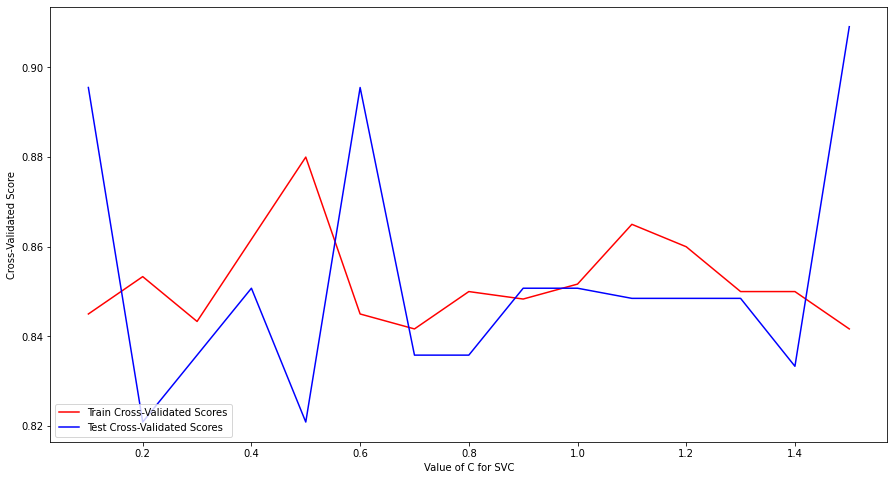

In [181]:
#plotting train and accuracy scores for RBF Kernel

C_range = list(np.arange(0.1,1.6,0.1))
plt.figure(figsize=(15,8))
#plt.subplot(1,2,1)
plt.plot(C_range, svc_scores_train, color='red')
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Score')
#plt.title('C Vs Train Accuracy Scores')
#plt.subplot(1,2,2)
plt.plot(C_range, svc_scores_test, color='blue')
#plt.xlabel('Value of C for SVC')
#plt.ylabel('Cross-Validated Accuracy')
#plt.title('C Vs Test Accuracy Scores')
plt.legend(['Train Cross-Validated Scores', 'Test Cross-Validated Scores'], loc='lower left')
plt.show()

Train Accuracy Scores: [0.7962222222222223, 0.7962222222222223, 0.8191111111111111, 0.8288888888888888]

Test Accuracy Scores: [0.7969999999999999, 0.7969999999999999, 0.7969999999999999, 0.825]


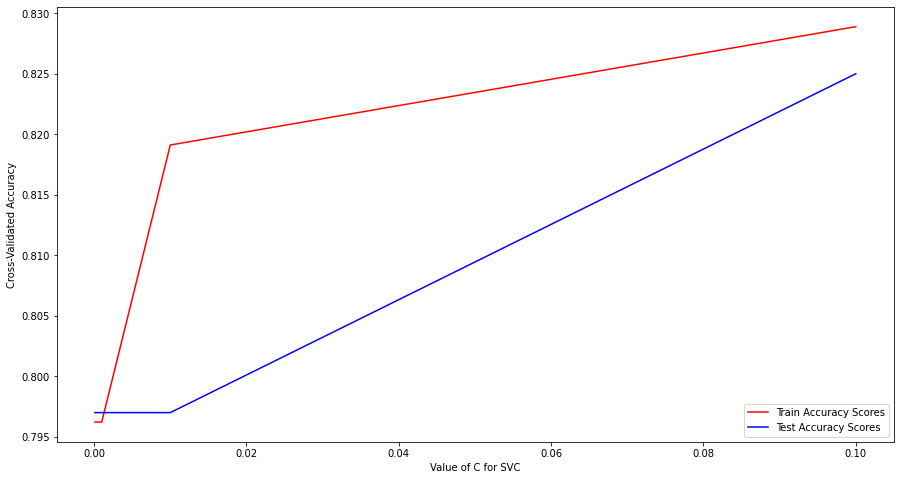

In [182]:
#plotting train and accuracy scores for different gamma vaues of RBF Kernel

gamma_range = [0.0001, 0.001, 0.01, 0.1]
train_acc_score = []
test_acc_score = []
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g)
    train_scores = cross_val_score(svc, X_scaled_train, Y_scaled_train, cv=10, scoring='accuracy')
    train_acc_score.append(train_scores.mean())
    test_scores = cross_val_score(svc, X_scaled_test, Y_scaled_test, cv=10, scoring='accuracy')
    test_acc_score.append(test_scores.mean())
print("Train Accuracy Scores:",train_acc_score)
print("\nTest Accuracy Scores:", test_acc_score)

plt.figure(figsize=(15,8))
plt.plot(gamma_range, train_acc_score, color='red')
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')
plt.plot(gamma_range, test_acc_score, color='blue')
plt.legend(['Train Accuracy Scores', 'Test Accuracy Scores'], loc='lower right')
plt.show()

In [184]:
#Fine-tuning the parameters using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'C':list(np.arange(1,10,0.5)),
              'gamma': [0.1, 0.5, 1, 1.5],
              'kernel': ['linear', 'rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

grid.fit(X_scaled_train, Y_scaled_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END ...C=1.0, gamma=0.1, kernel=linear;, score=0.818 total time=   1.7s
[CV 2/5] END ...C=1.0, gamma=0.1, kernel=linear;, score=0.819 total time=   1.9s
[CV 3/5] END ...C=1.0, gamma=0.1, kernel=linear;, score=0.818 total time=   1.3s
[CV 4/5] END ...C=1.0, gamma=0.1, kernel=linear;, score=0.822 total time=   1.0s
[CV 5/5] END ...C=1.0, gamma=0.1, kernel=linear;, score=0.818 total time=   1.0s
[CV 1/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.821 total time=   2.1s
[CV 2/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.825 total time=   2.1s
[CV 3/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.825 total time=   2.2s
[CV 4/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.826 total time=   2.0s
[CV 5/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.832 total time=   2.0s
[CV 1/5] END ...C=1.0, gamma=0.5, kernel=linear;, score=0.818 total time=   0.8s
[CV 2/5] END ...C=1.0, gamma=0.5, kernel=linea

[CV 2/5] END .....C=2.0, gamma=1, kernel=linear;, score=0.819 total time=   0.8s
[CV 3/5] END .....C=2.0, gamma=1, kernel=linear;, score=0.818 total time=   0.8s
[CV 4/5] END .....C=2.0, gamma=1, kernel=linear;, score=0.822 total time=   0.8s
[CV 5/5] END .....C=2.0, gamma=1, kernel=linear;, score=0.818 total time=   0.8s
[CV 1/5] END ........C=2.0, gamma=1, kernel=rbf;, score=0.845 total time=   2.1s
[CV 2/5] END ........C=2.0, gamma=1, kernel=rbf;, score=0.863 total time=   2.2s
[CV 3/5] END ........C=2.0, gamma=1, kernel=rbf;, score=0.844 total time=   2.0s
[CV 4/5] END ........C=2.0, gamma=1, kernel=rbf;, score=0.862 total time=   2.5s
[CV 5/5] END ........C=2.0, gamma=1, kernel=rbf;, score=0.849 total time=   2.4s
[CV 1/5] END ...C=2.0, gamma=1.5, kernel=linear;, score=0.818 total time=   1.0s
[CV 2/5] END ...C=2.0, gamma=1.5, kernel=linear;, score=0.819 total time=   0.9s
[CV 3/5] END ...C=2.0, gamma=1.5, kernel=linear;, score=0.818 total time=   0.8s
[CV 4/5] END ...C=2.0, gamma

[CV 4/5] END ...C=3.5, gamma=0.1, kernel=linear;, score=0.822 total time=   0.8s
[CV 5/5] END ...C=3.5, gamma=0.1, kernel=linear;, score=0.818 total time=   0.8s
[CV 1/5] END ......C=3.5, gamma=0.1, kernel=rbf;, score=0.837 total time=   1.8s
[CV 2/5] END ......C=3.5, gamma=0.1, kernel=rbf;, score=0.853 total time=   1.8s
[CV 3/5] END ......C=3.5, gamma=0.1, kernel=rbf;, score=0.846 total time=   1.8s
[CV 4/5] END ......C=3.5, gamma=0.1, kernel=rbf;, score=0.857 total time=   1.8s
[CV 5/5] END ......C=3.5, gamma=0.1, kernel=rbf;, score=0.842 total time=   1.8s
[CV 1/5] END ...C=3.5, gamma=0.5, kernel=linear;, score=0.818 total time=   0.8s
[CV 2/5] END ...C=3.5, gamma=0.5, kernel=linear;, score=0.819 total time=   0.8s
[CV 3/5] END ...C=3.5, gamma=0.5, kernel=linear;, score=0.818 total time=   0.8s
[CV 4/5] END ...C=3.5, gamma=0.5, kernel=linear;, score=0.822 total time=   0.8s
[CV 5/5] END ...C=3.5, gamma=0.5, kernel=linear;, score=0.818 total time=   0.8s
[CV 1/5] END ......C=3.5, ga

[CV 1/5] END ........C=4.5, gamma=1, kernel=rbf;, score=0.847 total time=   2.2s
[CV 2/5] END ........C=4.5, gamma=1, kernel=rbf;, score=0.860 total time=   2.1s
[CV 3/5] END ........C=4.5, gamma=1, kernel=rbf;, score=0.843 total time=   2.0s
[CV 4/5] END ........C=4.5, gamma=1, kernel=rbf;, score=0.862 total time=   2.2s
[CV 5/5] END ........C=4.5, gamma=1, kernel=rbf;, score=0.849 total time=   2.1s
[CV 1/5] END ...C=4.5, gamma=1.5, kernel=linear;, score=0.818 total time=   0.8s
[CV 2/5] END ...C=4.5, gamma=1.5, kernel=linear;, score=0.819 total time=   0.8s
[CV 3/5] END ...C=4.5, gamma=1.5, kernel=linear;, score=0.818 total time=   0.9s
[CV 4/5] END ...C=4.5, gamma=1.5, kernel=linear;, score=0.822 total time=   0.8s
[CV 5/5] END ...C=4.5, gamma=1.5, kernel=linear;, score=0.818 total time=   0.8s
[CV 1/5] END ......C=4.5, gamma=1.5, kernel=rbf;, score=0.850 total time=   2.1s
[CV 2/5] END ......C=4.5, gamma=1.5, kernel=rbf;, score=0.863 total time=   2.1s
[CV 3/5] END ......C=4.5, ga

[CV 3/5] END ......C=6.0, gamma=0.1, kernel=rbf;, score=0.848 total time=   1.8s
[CV 4/5] END ......C=6.0, gamma=0.1, kernel=rbf;, score=0.859 total time=   1.9s
[CV 5/5] END ......C=6.0, gamma=0.1, kernel=rbf;, score=0.845 total time=   1.8s
[CV 1/5] END ...C=6.0, gamma=0.5, kernel=linear;, score=0.818 total time=   0.8s
[CV 2/5] END ...C=6.0, gamma=0.5, kernel=linear;, score=0.819 total time=   0.8s
[CV 3/5] END ...C=6.0, gamma=0.5, kernel=linear;, score=0.818 total time=   0.9s
[CV 4/5] END ...C=6.0, gamma=0.5, kernel=linear;, score=0.822 total time=   0.9s
[CV 5/5] END ...C=6.0, gamma=0.5, kernel=linear;, score=0.818 total time=   0.9s
[CV 1/5] END ......C=6.0, gamma=0.5, kernel=rbf;, score=0.846 total time=   2.2s
[CV 2/5] END ......C=6.0, gamma=0.5, kernel=rbf;, score=0.863 total time=   2.2s
[CV 3/5] END ......C=6.0, gamma=0.5, kernel=rbf;, score=0.845 total time=   2.1s
[CV 4/5] END ......C=6.0, gamma=0.5, kernel=rbf;, score=0.858 total time=   2.1s
[CV 5/5] END ......C=6.0, ga

[CV 5/5] END ........C=7.0, gamma=1, kernel=rbf;, score=0.849 total time=   2.2s
[CV 1/5] END ...C=7.0, gamma=1.5, kernel=linear;, score=0.818 total time=   0.8s
[CV 2/5] END ...C=7.0, gamma=1.5, kernel=linear;, score=0.819 total time=   0.9s
[CV 3/5] END ...C=7.0, gamma=1.5, kernel=linear;, score=0.818 total time=   0.9s
[CV 4/5] END ...C=7.0, gamma=1.5, kernel=linear;, score=0.822 total time=   0.9s
[CV 5/5] END ...C=7.0, gamma=1.5, kernel=linear;, score=0.818 total time=   0.9s
[CV 1/5] END ......C=7.0, gamma=1.5, kernel=rbf;, score=0.849 total time=   2.2s
[CV 2/5] END ......C=7.0, gamma=1.5, kernel=rbf;, score=0.866 total time=   2.2s
[CV 3/5] END ......C=7.0, gamma=1.5, kernel=rbf;, score=0.848 total time=   2.1s
[CV 4/5] END ......C=7.0, gamma=1.5, kernel=rbf;, score=0.863 total time=   2.2s
[CV 5/5] END ......C=7.0, gamma=1.5, kernel=rbf;, score=0.852 total time=   2.2s
[CV 1/5] END ...C=7.5, gamma=0.1, kernel=linear;, score=0.818 total time=   0.9s
[CV 2/5] END ...C=7.5, gamma

[CV 2/5] END ...C=8.5, gamma=0.5, kernel=linear;, score=0.819 total time=   0.9s
[CV 3/5] END ...C=8.5, gamma=0.5, kernel=linear;, score=0.818 total time=   0.9s
[CV 4/5] END ...C=8.5, gamma=0.5, kernel=linear;, score=0.822 total time=   0.9s
[CV 5/5] END ...C=8.5, gamma=0.5, kernel=linear;, score=0.818 total time=   0.9s
[CV 1/5] END ......C=8.5, gamma=0.5, kernel=rbf;, score=0.847 total time=   2.2s
[CV 2/5] END ......C=8.5, gamma=0.5, kernel=rbf;, score=0.861 total time=   2.2s
[CV 3/5] END ......C=8.5, gamma=0.5, kernel=rbf;, score=0.846 total time=   2.1s
[CV 4/5] END ......C=8.5, gamma=0.5, kernel=rbf;, score=0.859 total time=   2.1s
[CV 5/5] END ......C=8.5, gamma=0.5, kernel=rbf;, score=0.846 total time=   2.1s
[CV 1/5] END .....C=8.5, gamma=1, kernel=linear;, score=0.818 total time=   0.9s
[CV 2/5] END .....C=8.5, gamma=1, kernel=linear;, score=0.819 total time=   0.9s
[CV 3/5] END .....C=8.5, gamma=1, kernel=linear;, score=0.818 total time=   0.9s
[CV 4/5] END .....C=8.5, gam

[CV 4/5] END ...C=9.5, gamma=1.5, kernel=linear;, score=0.822 total time=   0.9s
[CV 5/5] END ...C=9.5, gamma=1.5, kernel=linear;, score=0.818 total time=   0.9s
[CV 1/5] END ......C=9.5, gamma=1.5, kernel=rbf;, score=0.851 total time=   2.3s
[CV 2/5] END ......C=9.5, gamma=1.5, kernel=rbf;, score=0.867 total time=   2.3s
[CV 3/5] END ......C=9.5, gamma=1.5, kernel=rbf;, score=0.848 total time=   2.2s
[CV 4/5] END ......C=9.5, gamma=1.5, kernel=rbf;, score=0.867 total time=   2.3s
[CV 5/5] END ......C=9.5, gamma=1.5, kernel=rbf;, score=0.853 total time=   2.3s


GridSearchCV(estimator=SVC(),
             param_grid={'C': [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5,
                               6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5],
                         'gamma': [0.1, 0.5, 1, 1.5],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [185]:
#print best parameter after tuning
print("Best Parameters:\n",grid.best_params_)
print("Best Estimators:\n",grid.best_estimator_)

Best Parameters:
 {'C': 8.5, 'gamma': 1.5, 'kernel': 'rbf'}
Best Estimators:
 SVC(C=8.5, gamma=1.5)


In [186]:
grid_predictions = grid.predict(X_scaled_test)
print("SVC Confusion Matrix:\n",confusion_matrix(Y_scaled_test, grid_predictions))
print("Classification Report:\n",classification_report(Y_scaled_test, grid_predictions))

SVC Confusion Matrix:
 [[770  27]
 [103 100]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       797
           1       0.79      0.49      0.61       203

    accuracy                           0.87      1000
   macro avg       0.83      0.73      0.76      1000
weighted avg       0.86      0.87      0.86      1000



In [187]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [188]:
#Using KNN Classifier after removing unimportant features with Default params
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
i=1
for train_index, test_index in folds.split(X_scaled_new,Y_scaled):
    print("\n {} of KFold".format(i,folds.n_splits))
    X_scaled_train,X_scaled_test = X_scaled_new.iloc[train_index],X_scaled_new.iloc[test_index]
    Y_scaled_train,Y_scaled_test = Y_scaled.iloc[train_index],Y_scaled.iloc[test_index]
    knn.fit(X_scaled_train,Y_scaled_train)
    y_scaled_test_pred = knn.predict(X_scaled_test)

    print("PERFORMANCE FOR KNN")
    knn_scores = cross_val_score(knn, X_scaled_train, Y_scaled_train, cv=5)
    print("Mean cross validation score: {}".format(np.mean(knn_scores)))
    print("KNN Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_scaled_test_pred))
    print("KNN Classification Report: \n")
    print(classification_report(Y_scaled_test, y_scaled_test_pred))
    i=i+1


 1 of KFold
PERFORMANCE FOR KNN
Mean cross validation score: 0.8372222222222222
KNN Confusion Matrix:
 [[745  51]
 [117  87]]
KNN Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       796
           1       0.63      0.43      0.51       204

    accuracy                           0.83      1000
   macro avg       0.75      0.68      0.70      1000
weighted avg       0.82      0.83      0.82      1000


 2 of KFold
PERFORMANCE FOR KNN
Mean cross validation score: 0.8405555555555555
KNN Confusion Matrix:
 [[746  50]
 [117  87]]
KNN Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       796
           1       0.64      0.43      0.51       204

    accuracy                           0.83      1000
   macro avg       0.75      0.68      0.70      1000
weighted avg       0.82      0.83      0.82      1000


 3 of KFold
PERFORMANCE FOR KNN
M

In [189]:
error_rate = []
for i in range(1,140):
        knn.fit(X_scaled_train,Y_scaled_train)
        y_scaled_test_pred = knn.predict(X_scaled_test)
        y_scaled_test_pred = y_scaled_test_pred.reshape(1000,1)
        error_rate.append(np.mean(y_scaled_test_pred != Y_scaled_test))

In [190]:
error_rate = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_scaled_train,Y_scaled_train)
    y_scaled_test_pred = knn.predict(X_scaled_test)
    y_scaled_test_pred = y_scaled_test_pred.reshape(1000,1)
    error_rate.append(np.mean(y_scaled_test_pred != Y_scaled_test))

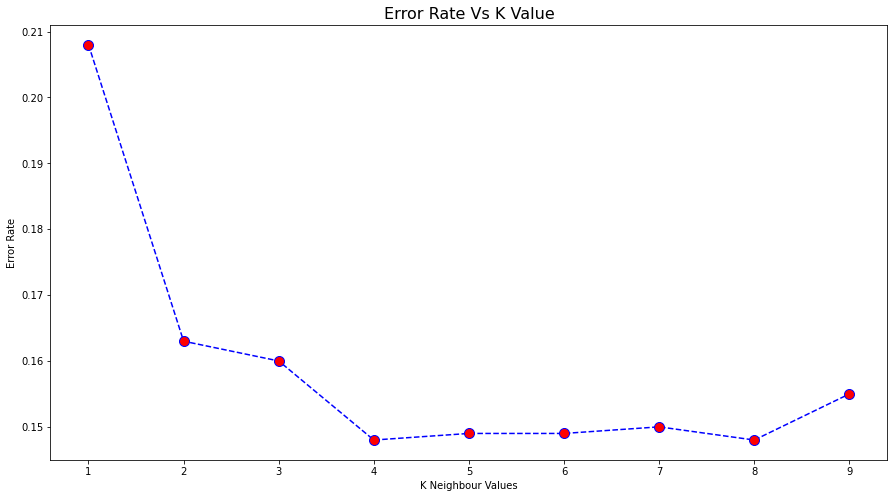

In [191]:
plt.figure(figsize=(15,8))
plt.plot(range(1,10),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title("Error Rate Vs K Value", fontsize=16)
plt.xlabel("K Neighbour Values")
plt.ylabel("Error Rate")
plt.show()

In [192]:
#Parameter tuning with GridSearchCV 
estimator_KNN = KNeighborsClassifier()
parameters_KNN = {
    'n_neighbors': (1,20, 1),
    'leaf_size': (1,10,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    'metric': ('minkowski', 'chebyshev')}
                   

grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    n_jobs = -1,
    cv = 5
)

In [193]:
KNN_1=grid_search_KNN.fit(X_scaled_train, Y_scaled_train)
y_pred_KNN1 =KNN_1.predict(X_scaled_test)

In [194]:
#Parameter setting that gave the best results on the hold out data.
print(grid_search_KNN.best_params_ ) 

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}


In [195]:
print('Best Score - KNN:', grid_search_KNN.best_score_ )

Best Score - KNN: 0.8491111111111111


In [196]:
print("KNN Confusion Matrix:\n",confusion_matrix(Y_scaled_test, y_pred_KNN1))
print("KNN Classification Report: \n")
print(classification_report(Y_scaled_test, y_pred_KNN1))

KNN Confusion Matrix:
 [[761  36]
 [108  95]]
KNN Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       797
           1       0.73      0.47      0.57       203

    accuracy                           0.86      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.85      0.86      0.84      1000



{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best Score - KNN: 0.8486666666666667
